In [9]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [10]:
%load_ext autoreload
%autoreload 2
import cProfile
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, HELMConverter

config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_path"))
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(model_dir)) + ".lang"
    lang_path = add_sep(model_dir) + lang_name
lang = Language.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_conf = reward_conf or {}
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Search is started.
0- time: 0.00, reward: -0.8820233967157689, node: PEPTIDE1{R.P.[dK].P.[dQ].Q.[dW].F.G.[dL].M.[am]}$$$$
1- time: 0.03, reward: -0.8990291398904394, node: PEPTIDE1{[Glp].L.Y.E.N.K.P.R.R.P.Y.I.L}$$$$
2- time: 0.09, reward: -0.8840130335515618, node: PEPTIDE1{R.[dP].K.[dP].[dQ].[dQ].F.F.G.L.M.[am]}$$$$
3- time: 0.12, reward: -0.9012621172331091, node: PEPTIDE1{Y.G.G.F.L.R.R.I.R.P.K.L.K.[am]}$$$$
4- time: 0.15, reward: -0.8959138524157674, node: PEPTIDE1{G.[dC].C.S.H.P.[Abu].C.F.W.L.T.C}$$$$
5- time: 0.18, reward: -0.6683050630981698, node: PEPTIDE1{F.V.W.I.H.P}$$$$
6- time: 0.20, reward: 0.9384259465015717, node: PEPTIDE1{A.A.G.A.A.A.A.[am]}$$$$
7- time: 0.22, reward: 0.9405976728642852, node: PEPTIDE1{A.A.E.V.C.D}$$$$
8- time: 0.24, reward: 0.9480378850947636, node: PEPTIDE1{A.A.A}$$$$
9- time: 0.25, reward: 0.9355560890567386, node: PEPTIDE1{A.A.A.A.A.G.A.A.V.[am]}$$$$
10- time: 0.27, reward: 0.934531920713402, node: PEPTIDE1{A.A.A.A.A.A.A.A.A.V.L.[am]}$$$$
11- time: 0

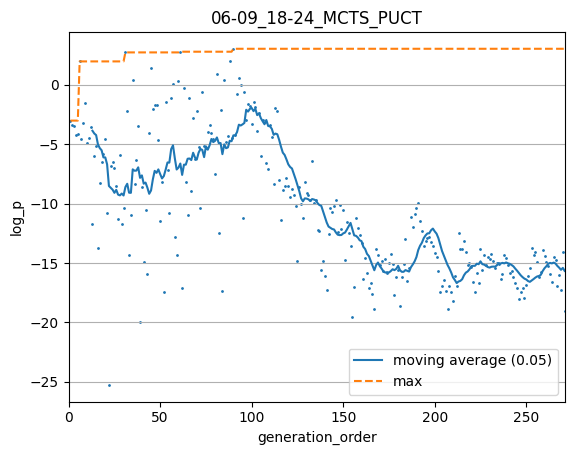

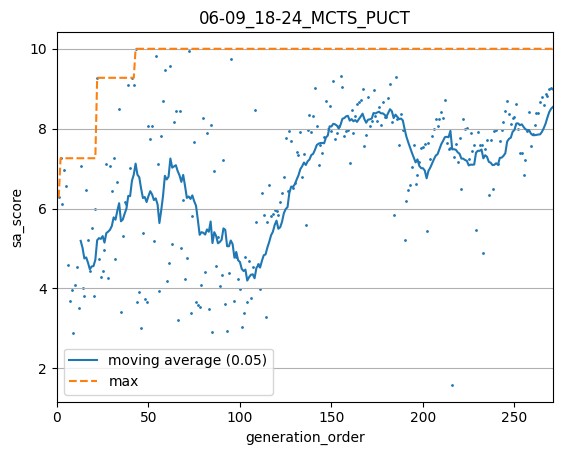

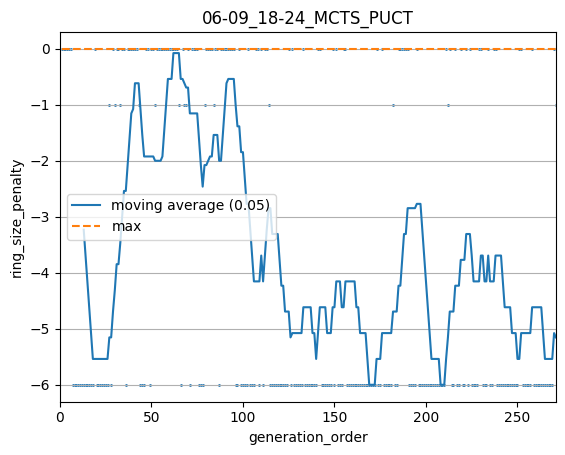

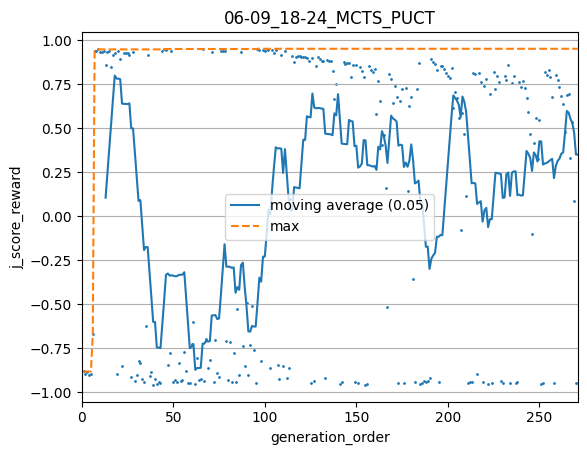

In [11]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization

output_dir, generator_conf, filtered_reward = (conf.get(k) for k in ("output_dir", "generator_conf", "filtered_reward"))
generator = MCTS(root=root, transition=model, reward=reward, policy=policy, filters=filters, filtered_reward=filtered_reward, output_dir=output_dir, **generator_conf)
src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

time_limit, max_generations = (conf.get(k) for k in ("time_limit", "max_generations"))
generator.generate(time_limit=time_limit, max_generations=max_generations)
# cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
# generator.plot_objective_values_and_reward(x_axis = "time")

In [12]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [13]:
#load mcts
generator = MCTS.load(save_path, model)